# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [60]:
# Load environment variables
%reload_ext dotenv
%dotenv 


In [61]:
# breaking these lines up as I troubleshoot, why I couldn't load my data set - found out I saved my file directory in the wrong env file (01_materials)
import os
print("FIRES_DATA =", os.getenv("FIRES_DATA"))

FIRES_DATA = ../../05_src/data/fires/forestfires.csv


In [62]:

# Standard libraries
import pandas as pd
import numpy as np


# Load data
ft_file = os.getenv("FIRES_DATA") # added this to my .env file in 02_activites now
df_raw = pd.read_csv(ft_file) 


In [63]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [64]:
# always reviewing
fires_dt.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Get X and Y

Create the features data frame and target data.

In [65]:
# setting up X and y, to predict the area affected by forest fire
df = df_raw.copy()

X = df.drop(columns=["area"])
y = df['area']



In [66]:
# reviewing changes
X.info()
y.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 48.6+ KB


count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

In [67]:
# sanity check review
cat_cols = ['month', 'day']
num_cols = [c for c in X.columns if c not in cat_cols]


In [68]:
#sanity check review
cat_cols

['month', 'day']

In [69]:
# sanity check review
num_cols

['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer # encode the catergorial columns / power transform to help with skew / non-numerical features
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge # regressor

cat_cols = ['month', 'day']

num_cols = [
    'coord_x', 'coord_y',
    'ffmc', 'dmc', 'dc', 'isi',
    'temp', 'rh', 'wind', 'rain'
]

pipe_num_simple = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

pipe_cat_simple = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ctransform_simple = ColumnTransformer([
    ('num', pipe_num_simple, num_cols),
    ('cat', pipe_cat_simple, cat_cols)
], remainder='drop') # setting reminder

pipe_simple = Pipeline([
    ('preprocess', ctransform_simple),
    ('model', Ridge())
])

pipe_simple

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [71]:
pipe_simple.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('scaler', StandardScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['month', 'day'])])),
  ('model', Ridge())],
 'transform_input': None,
 'verbose': False,
 'preprocess': ColumnTransformer(tr

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [72]:
# Columns
cat_cols = ['month', 'day']
num_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

# Preproc 1: scale numeric + one-hot categorical

num_pipe_1 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preproc1 = ColumnTransformer([
    ('num', num_pipe_1, num_cols),
    ('cat', cat_pipe, cat_cols)
])

In [73]:
preproc1

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [74]:
preproc1.get_params()

{'force_int_remainder_cols': 'deprecated',
 'n_jobs': None,
 'remainder': 'drop',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('num',
   Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                   ('scaler', StandardScaler())]),
   ['coord_x',
    'coord_y',
    'ffmc',
    'dmc',
    'dc',
    'isi',
    'temp',
    'rh',
    'wind',
    'rain']),
  ('cat',
   Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                   ('onehot', OneHotEncoder(handle_unknown='ignore'))]),
   ['month', 'day'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'num': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler())]),
 'cat': Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                 ('onehot', OneHotEncoder(handle_unknown='ignore'))]),
 'num__memory': None,
 'num__steps': [('imputer', SimpleImputer(strategy='median')),
  ('scale

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [75]:
# Columns
cat_cols = ['month', 'day']
num_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

# Preproc 2: non-linear transform + scale numeric + one-hot categorical
num_pipe_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson')),  # works with zeros/negatives
    ('scaler', StandardScaler())
])

preproc2 = ColumnTransformer([
    ('num', num_pipe_2, num_cols),
    ('cat', cat_pipe, cat_cols)
])


In [76]:
preproc2

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [77]:
preproc2.get_params()

{'force_int_remainder_cols': 'deprecated',
 'n_jobs': None,
 'remainder': 'drop',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('num',
   Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                   ('power', PowerTransformer()), ('scaler', StandardScaler())]),
   ['coord_x',
    'coord_y',
    'ffmc',
    'dmc',
    'dc',
    'isi',
    'temp',
    'rh',
    'wind',
    'rain']),
  ('cat',
   Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                   ('onehot', OneHotEncoder(handle_unknown='ignore'))]),
   ['month', 'day'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'num': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('power', PowerTransformer()), ('scaler', StandardScaler())]),
 'cat': Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                 ('onehot', OneHotEncoder(handle_unknown='ignore'))]),
 'num__memory': None,
 'num__ste

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [78]:
# import additional libraries
from sklearn.ensemble import RandomForestRegressor

# Baseline regressor
ridge = Ridge(random_state=42)

# Advanced regressor (tree-based)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

In [79]:
# Pipeline A = preproc1 + baseline
pipe_A = Pipeline([
    ('preprocessing', preproc1), # step labelled preprocessing + column transformer
    ('regressor', ridge) # regression step
])

In [80]:
# checking
pipe_A

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [81]:
# Pipeline B = preproc2 + baseline
pipe_B = Pipeline([
    ('preprocessing', preproc2), # step labelled preprocessing + column transformer
    ('regressor', ridge) # regression step
])

In [82]:
# checking
pipe_B

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [83]:
# Pipeline C = preproc1 + advanced model
pipe_C = Pipeline([
    ('preprocessing', preproc1), # step labelled preprocessing + column transformer
    ('regressor', rf) #regression step, advanced random forest
])

In [84]:
#checking 
pipe_C

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [85]:
# Pipeline D = preproc2 + advanced model
pipe_D = Pipeline([
    ('preprocessing', preproc2), # step labelled preprocessing + column transformer
    ('regressor', rf) #regression step, , advanced random forest
])
    

In [86]:
# checking
pipe_D

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [87]:
# setting up tunning grids
param_grid_ridge = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

param_grid_rf = {
    'regressor__n_estimators': [200, 500],
    'regressor__max_depth': [None, 5, 10, 20],
    'regressor__min_samples_leaf': [1, 2, 5]
}

In [88]:
# grid search + cross-validation evaluation (RMSE)
# load more libraries 
# - GridSearchCV: hyperparameter tuning
# - cross_validate: evaluate multiple metrics via cross-validation
# - KFold: define how data is split into folds
from sklearn.model_selection import GridSearchCV, cross_validate, KFold

# Define the cross-validation strategy
# - 5 folds, shuffle to randomize data, fixed random_state for reproducibility

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

def tune_and_eval(pipe, param_grid, X, y, label):
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',  # primary metric for model selection
        cv=cv,
        n_jobs=-1
    )
    gs.fit(X, y)

    cv_res = cross_validate(
        gs.best_estimator_,
        X, y,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        return_train_score=False
    )

    out = {
        'pipeline': label,
        'best_params': gs.best_params_,
        'rmse_mean': -cv_res['test_rmse'].mean(),
        'rmse_std': cv_res['test_rmse'].std(),
        'mae_mean': -cv_res['test_mae'].mean(),
        'r2_mean': cv_res['test_r2'].mean()
    }
    return gs.best_estimator_, out


In [89]:
#  something happened when I installed SHAP, I restarted the kernal and now my pipelines don't run, I am trouble shooting
X.columns.tolist()

['X',
 'Y',
 'month',
 'day',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain']

In [90]:
# trouble shooting
X = fires_dt.drop(columns=['area'])
y = fires_dt['area']

In [91]:
#rouble shooting
print(X.columns)
print(y.name)

Index(['coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi',
       'temp', 'rh', 'wind', 'rain'],
      dtype='object')
area


In [92]:
# round 2 of trouble shooting post SHAP install
#running pipeline A, was having issues running them all together, i am trouble shooting :)
best_A, res_A = tune_and_eval(pipe_A, param_grid_ridge, X, y, "A: preproc1 + Ridge")
res_A

{'pipeline': 'A: preproc1 + Ridge',
 'best_params': {'regressor__alpha': 100.0},
 'rmse_mean': np.float64(54.272154873827866),
 'rmse_std': np.float64(32.92789727659575),
 'mae_mean': np.float64(19.53122289944701),
 'r2_mean': np.float64(-0.07476376761488986)}

In [93]:
#working now - unsure what I did
best_B, res_B = tune_and_eval(pipe_B, param_grid_ridge, X, y, "B: preproc2 + Ridge")
best_C, res_C = tune_and_eval(pipe_C, param_grid_rf,    X, y, "C: preproc1 + RF")
best_D, res_D = tune_and_eval(pipe_D, param_grid_rf,    X, y, "D: preproc2 + RF")

Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "c:\Users\Brianna\production\production-env\Lib\site-packages\psutil\_pswindows.py", line 673, in wrapper
    return fun(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Brianna\production\production-env\Lib\site-packages\psutil\_pswindows.py", line 851, in kill
    return cext.proc_kill(self.pid)
           ^^^^^^^^^^^^^^^^^^^^^^^^
PermissionError: [WinError 5] Access is denied: '(originated from OpenProcess)'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Brianna\AppData\Roaming\uv\python\cpython-3.11.14-windows-x86_64-none\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\Brianna\production\production-env\Lib\site-packages\joblib\externals\loky\process_executor.py", line 635, in run
    self.flag_executor_shutting_down()
  File "c:\Users\Brianna\production\producti

KeyboardInterrupt: 

In [ ]:
res_B # B: preproc2 + Ridge

{'pipeline': 'B: preproc2 + Ridge',
 'best_params': {'regressor__alpha': 100.0},
 'rmse_mean': np.float64(54.10873021677967),
 'rmse_std': np.float64(33.02283333933058),
 'mae_mean': np.float64(19.33215325304786),
 'r2_mean': np.float64(-0.06055398814480082)}

In [ ]:
res_C # C: preproc1 + RF

{'pipeline': 'C: preproc1 + RF',
 'best_params': {'regressor__max_depth': 5,
  'regressor__min_samples_leaf': 5,
  'regressor__n_estimators': 500},
 'rmse_mean': np.float64(57.77217963228446),
 'rmse_std': np.float64(30.870277725074697),
 'mae_mean': np.float64(20.613737597218293),
 'r2_mean': np.float64(-0.36288224326870566)}

In [ ]:
res_D # D: preproc2 + RF

{'pipeline': 'D: preproc2 + RF',
 'best_params': {'regressor__max_depth': 5,
  'regressor__min_samples_leaf': 5,
  'regressor__n_estimators': 500},
 'rmse_mean': np.float64(57.78889047078377),
 'rmse_std': np.float64(30.855868145982118),
 'mae_mean': np.float64(20.602004930907505),
 'r2_mean': np.float64(-0.36428182278187915)}

In [ ]:
results_df = (
    pd.DataFrame([res_A, res_B, res_C, res_D])
      .sort_values("rmse_mean")   # best = smallest RMSE
      .reset_index(drop=True)
)

results_df # reviewing the results of all 4 pipelines

,pipeline,best_params,rmse_mean,rmse_std,mae_mean,r2_mean
0,B: preproc2 + Ridge,{'regressor__alpha': 100.0},54.108730,33.022833,19.332153,-0.060554
1,A: preproc1 + Ridge,{'regressor__alpha': 100.0},54.272155,32.927897,19.531223,-0.074764
2,C: preproc1 + RF,"{'regressor__max_depth': 5, 'regressor__min_sa...",57.772180,30.870278,20.613738,-0.362882
3,D: preproc2 + RF,"{'regressor__max_depth': 5, 'regressor__min_sa...",57.788890,30.855868,20.602005,-0.364282


In [ ]:
# trying out how to idenitfy the pipeline programatically, to confirm above ranking
best_pipeline = results_df.iloc[0]
best_pipeline

pipeline               B: preproc2 + Ridge
best_params    {'regressor__alpha': 100.0}
rmse_mean                         54.10873
rmse_std                         33.022833
mae_mean                         19.332153
r2_mean                          -0.060554
Name: 0, dtype: object

# Evaluate

+ Which model has the best performance?

As this is a prediction problem related to regression, the best model has the lowest rmse_mean, which is pipeline B, also confirmed when I programmtically sorted the rmse_mean. 

# Export

+ Save the best performing model to a pickle file.

In [ ]:
# turning models in winning model object
winning_pipeline_name = results_df.iloc[0]['pipeline']

best_models = {
    'B: preproc2 + Ridge': best_B,

}

best_model = best_models[winning_pipeline_name]

In [ ]:
# checking
best_B

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
#importing pickle library
import pickle

# saving model into a pickle file
with open("best_model_B_forest_fires.pkl", "wb") as f:
    pickle.dump(best_B, f)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [117]:
# i tried installing and importing shap but it won't play nice
#pip install shap
#trying this way
# found our I didn't have pip installed in this envrionment - so I added that in gitbash in my environment
%pip install shap




Note: you may need to restart the kernel to use updated packages.


In [118]:
#ran the upgrade pip in bash and now can import shap
import shap

In [119]:
# i am recreating my X and y to then do train/test split
from sklearn.model_selection import train_test_split
import numpy as np

# Features + target
X = fires_dt.drop(columns=["area"])
y = fires_dt["area"]

#  log-transform target because area is very skewed - I looked this up, was going to add to my first block of code but i did and something broke in pipeline, and I am ready to be done this
y_log = np.log1p(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)


In [120]:
# Extract preprocessing + model
preprocessor = best_B.named_steps["preprocessing"]
regressor = best_B.named_steps["regressor"]

# Transform training & test data
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

In [121]:
# sanity check
print(X_train.shape, X_train_proc.shape)
print(feature_names[:10])

(413, 12) (413, 29)
['num__coord_x' 'num__coord_y' 'num__ffmc' 'num__dmc' 'num__dc' 'num__isi'
 'num__temp' 'num__rh' 'num__wind' 'num__rain']


In [113]:
# small background sample for speed
background = shap.sample(X_train_proc, 50, random_state=42)

# explain predictions
explainer = shap.Explainer(regressor.predict, background)
shap_values = explainer(X_test_proc)

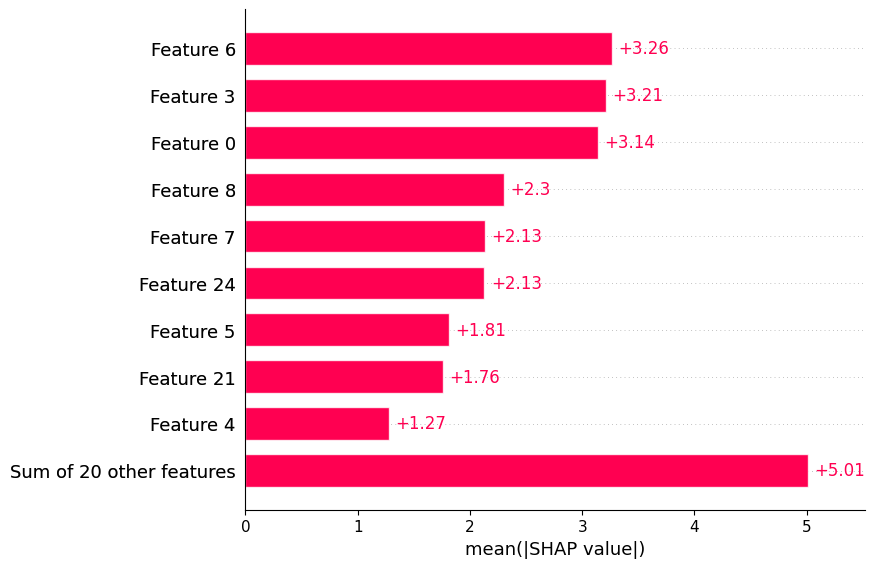

In [114]:
# graphs!
shap.plots.bar(shap_values)

In [115]:
# shap explainer, model agnostic set up
global_imp = np.mean(np.abs(shap_values.values), axis=0)
imp_df = pd.DataFrame({"feature": feature_names, "mean_abs_shap": global_imp})
imp_df = imp_df.sort_values("mean_abs_shap", ascending=False)

imp_df.head(15), imp_df.tail(15)

(           feature  mean_abs_shap
 6        num__temp       3.263595
 3         num__dmc       3.212391
 0     num__coord_x       3.140250
 8        num__wind       2.301378
 7          num__rh       2.133747
 24    cat__day_sat       2.129316
 5         num__isi       1.811232
 21  cat__month_sep       1.759766
 4          num__dc       1.274515
 11  cat__month_aug       0.931471
 1     num__coord_y       0.911270
 22    cat__day_fri       0.775232
 9        num__rain       0.597026
 2        num__ffmc       0.411311
 17  cat__month_mar       0.328703,
            feature  mean_abs_shap
 17  cat__month_mar       0.328703
 28    cat__day_wed       0.220616
 25    cat__day_sun       0.214180
 23    cat__day_mon       0.195406
 16  cat__month_jun       0.113576
 26    cat__day_thu       0.102185
 13  cat__month_feb       0.082572
 15  cat__month_jul       0.053993
 12  cat__month_dec       0.034143
 27    cat__day_tue       0.021404
 20  cat__month_oct       0.009580
 10  cat__month_apr

In [116]:
type(best_B.named_steps["regressor"])

sklearn.linear_model._ridge.Ridge

*(Answer here.)*

SHAP values were used to explain both individual predictions and overall feature importance for the best-performing model.

For a selected test observation, the prediction is primarily driven by temperature, fuel moisture indices (DMC, ISI), and wind speed, which increase the predicted burned area. Relative humidity and rainfall reduce the prediction, while day-of-week and month variables have little influence on this specific case.

Globally, the model relies most on temperature, fuel moisture indices (DMC, DC, ISI), wind, relative humidity, and spatial coordinates, all of which show the highest mean absolute SHAP values. In contrast, many month and day-of-week indicators contribute minimally, suggesting limited predictive value.

Based on these results, low-importance categorical features could be removed to simplify the model. This would be validated by retraining the model without these features and comparing cross-validated performance metrics (RMSE, MAE, R²) to ensure predictive performance is maintained or improved.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.